# Predicting Spotify Song Popularity with PyTorch


## Introduction


The project applies PyTorch, a leading deep learning framework, to the task of predicting Spotify’s popularity score (0–100) for songs based on their audio features. Our goal is to collaboratively build a neural network capable of estimating a song’s popularity using attributes such as danceability, energy, valence, tempo, and more.

By shifting from traditional machine learning approaches to a neural network–based solution, we aim to gain practical experience with an industry-standard tool while addressing a real-world regression problem. The project will involve designing, training, and evaluating multiple network architectures, with a focus on improving performance through iterative experimentation.


## 🔥 Introduction to PyTorch

**PyTorch** is an open-source deep learning library developed by Facebook AI Research, widely used for building machine learning and neural network models.

### ⚡ Key Features

- **Dynamic computation graph (define-by-run):** Build models on the fly, making it flexible and easy to debug.
- **Tensors:** Core data structure, similar to NumPy arrays but with GPU acceleration.
- **Autograd:** Automatic differentiation for easy backpropagation.
- **Neural Network Module (`torch.nn`):** Provides layers, activation functions, loss functions, and optimizers.
- **Optimizers (`torch.optim`):** Includes SGD, Adam, RMSProp, etc., for parameter updates.
- **GPU/CPU flexibility:** Easily switch between CPU and GPU for faster computation.
- **Rich ecosystem:** Extensions like `torchvision` (vision), `torchaudio` (audio), `torchtext` (NLP).

### 🚀 Why PyTorch?

- Easy to learn and Pythonic — feels like writing regular Python code.
- Great for research prototyping and experimentation.
- Scales to production with TorchScript and ONNX.
- Backed by a large community and widely adopted in both **academia** and **industry**.


In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Data loading and Preprocessing


In [26]:
# Load the dataset
data = pd.read_csv('dataset/SpotifyFeatures.csv')

In [27]:
# Display the first few rows of the dataset
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [28]:
# Display the shape of 'data' DataFrame 
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns") 

The DataFrame has 232725 rows and 18 columns


In [29]:
# Display informative summary of the 'data' DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [30]:
# Check for any duplicates in the dataframe
duplicates = data[data.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 0


- It can be observed that there are no duplicates in the data.


In [31]:
# Check for missing values in 'data' DataFrame
display(data.isna().sum())

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

- There are no missing values


In [32]:
# Drop missing values
data = data.dropna()

# Check for missing values again
data.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

### Removing Irrelevant Features


In [33]:
# Let's remove some obvious irrelevant features
data = data.drop(columns=['track_id', 'track_name', 'artist_name'])

### Dropped Features

- **track_id** → Just a unique identifier; carries no predictive value.
- **track_name** → Song title text; unstructured, very high dimensional, and not meaningful for predicting popularity.
- **artist_name** → Very high cardinality and potential **data leakage**.
  - Popular artists typically have higher popularity.
  - This allows the model to _memorize specific artists_ rather than learning from audio features.

Keeping them may add noise or unnecessary complexity, so we removed them before training the model. By removing them, we keep only meaningful numerical/audio features for training.


In [34]:
# Quick look
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   popularity        232725 non-null  int64  
 2   acousticness      232725 non-null  float64
 3   danceability      232725 non-null  float64
 4   duration_ms       232725 non-null  int64  
 5   energy            232725 non-null  float64
 6   instrumentalness  232725 non-null  float64
 7   key               232725 non-null  object 
 8   liveness          232725 non-null  float64
 9   loudness          232725 non-null  float64
 10  mode              232725 non-null  object 
 11  speechiness       232725 non-null  float64
 12  tempo             232725 non-null  float64
 13  time_signature    232725 non-null  object 
 14  valence           232725 non-null  float64
dtypes: float64(9), int64(2), object(4)
memory usage: 26.6+ MB


## Exploratory Data Analysis(EDA)


### Exploring the Distribution of Numerical Features

Before building the model, it’s important to understand how each numerical feature is distributed.  
This helps us:

- Detect skewness or outliers
- Identify features that may need scaling or transformation
- Get an overall sense of the dataset’s structure

We will plot histograms for each numerical column in the dataset.


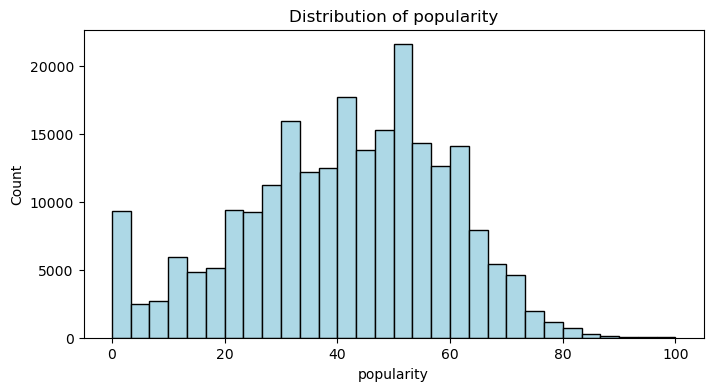

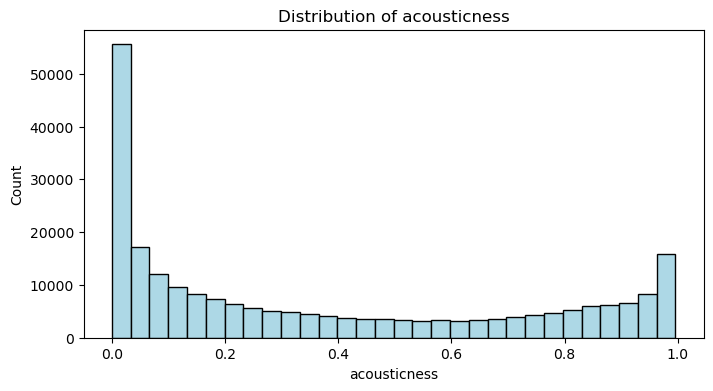

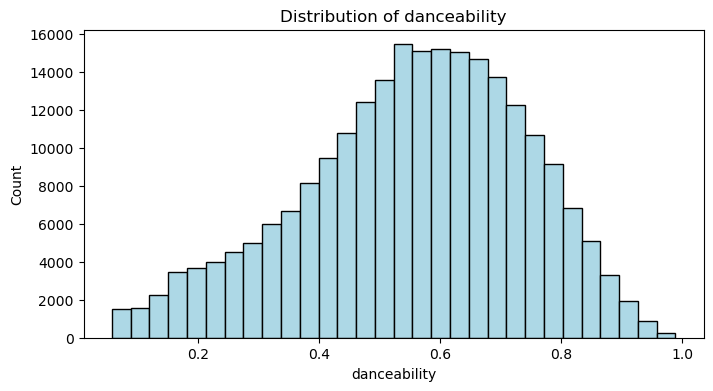

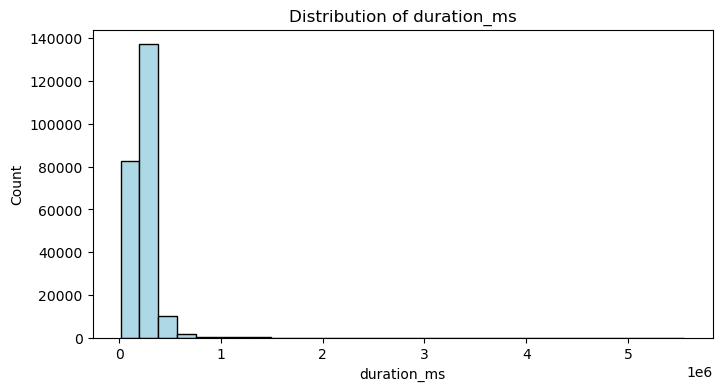

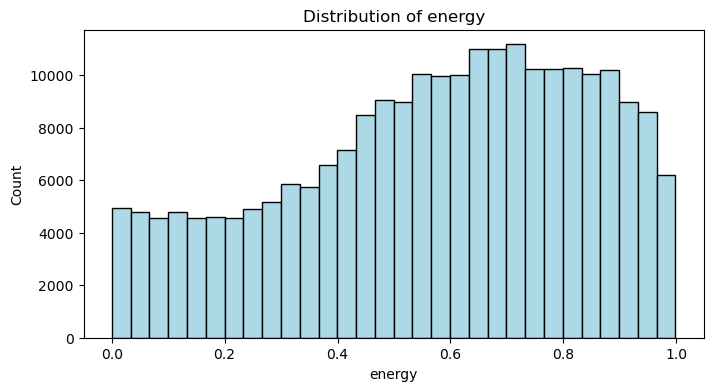

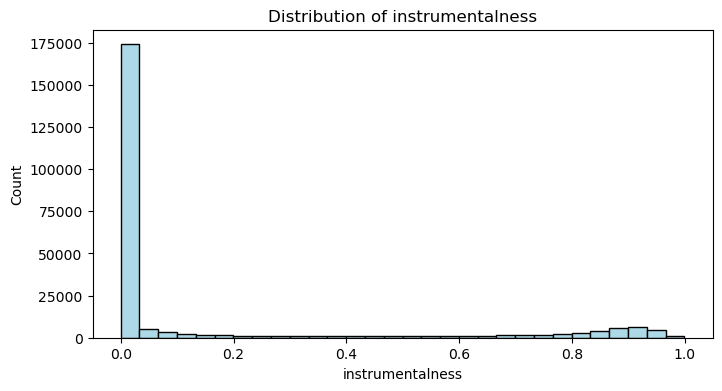

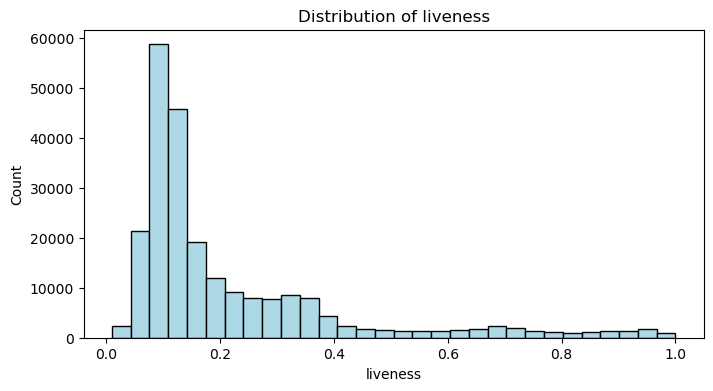

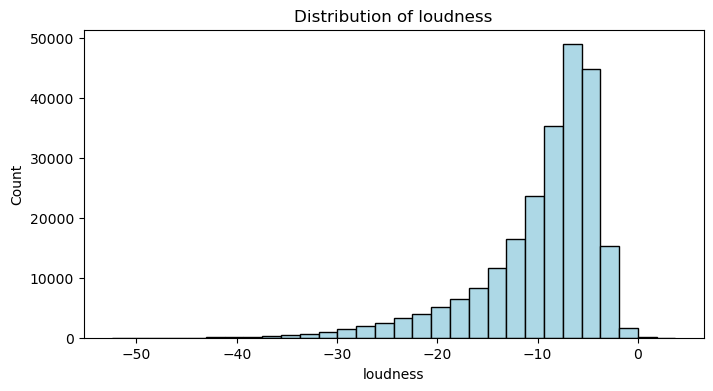

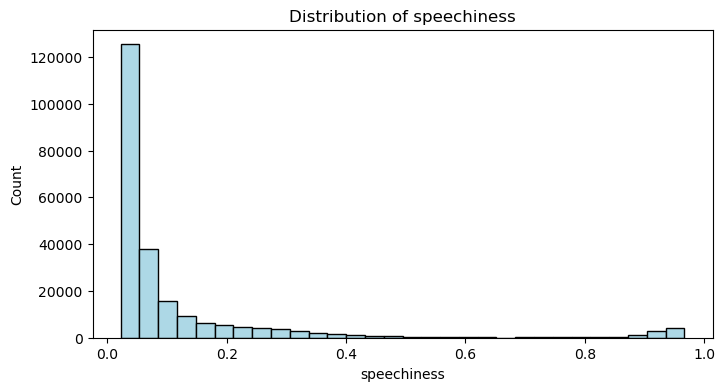

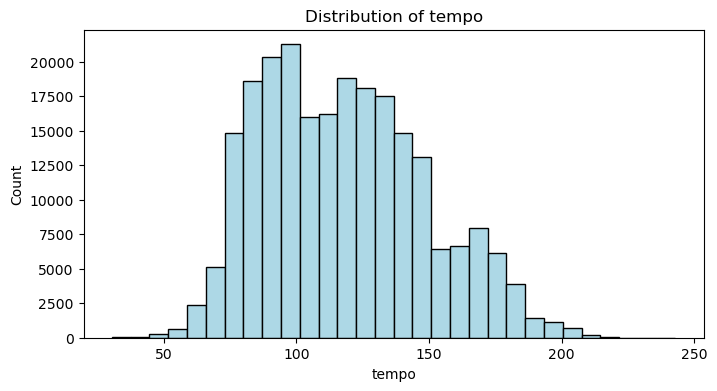

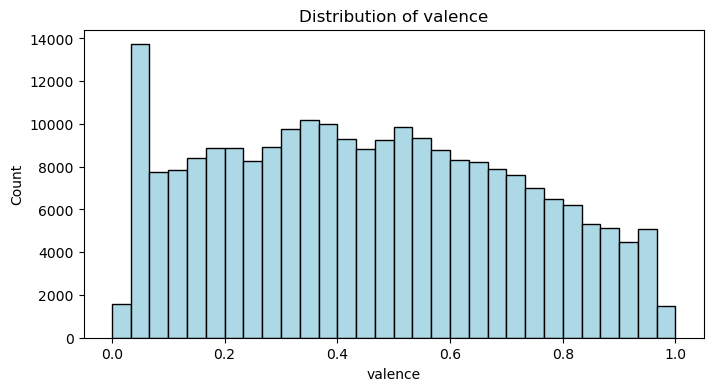

In [35]:
# Lets explore the distribution of numerical features

# Select numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

for one_col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(data[one_col], bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of {one_col}')
    plt.xlabel(one_col)
    plt.ylabel('Count')
    plt.show()

The feature `duration_ms` distribution is too extreme. So it is better to log tranform that.


In [36]:
# log transform 
data['duration_ms_log'] = np.log1p(data['duration_ms'])

# drop original column
data = data.drop(columns=['duration_ms'])

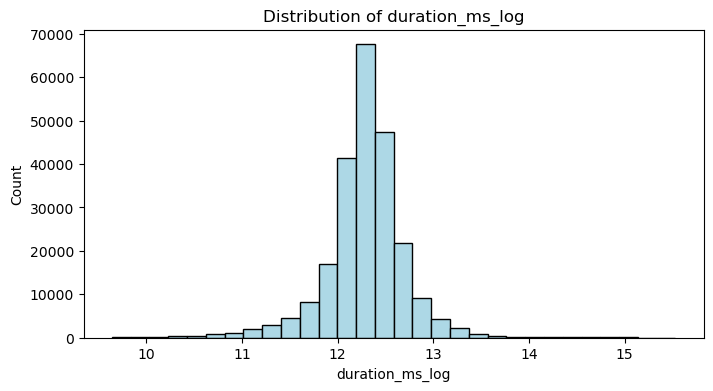

In [37]:
# Distribution after log transformation
plt.figure(figsize=(8, 4))
plt.hist(data['duration_ms_log'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of duration_ms_log')
plt.xlabel('duration_ms_log')
plt.ylabel('Count')
plt.show()

- Now, the data is normally distributed.


In [38]:
# Lets explore some categorical columns
# `time_signature` feature

data['time_signature'].value_counts()

4/4    200760
3/4     24111
5/4      5238
1/4      2608
0/4         8
Name: time_signature, dtype: int64

- In our dataset, **"4/4" dominates**: it accounts for the vast majority of tracks (over 85%).
- Instead of representing all time signatures, we encode as `1` if `time_signature` is "4/4", else `0`.
- This approach **reduces dimensionality and noise**.


In [39]:
# Create a binary column

data['time_signature'] = np.where(data['time_signature'] == '4/4', 1, 0)

# Quick check
data['time_signature'].value_counts()

1    200760
0     31965
Name: time_signature, dtype: int64

In [40]:
# Let's explore `mode`
data['mode'].value_counts()

Major    151744
Minor     80981
Name: mode, dtype: int64

We can engineer a feature to create a binary column.


### Converting Categorical Column `mode` into Binary

The `mode` column indicates whether a track is in a **Major** or **Minor** key.  
Since machine learning models work better with numerical features, we map:

- `Major` → 1
- `Minor` → 0

This creates a binary representation that can be used directly in training.


In [41]:
# Create a binary column
data['mode'] = data['mode'].map({'Major': 1, 'Minor': 0})

# Quick check
data['mode'].value_counts()

1    151744
0     80981
Name: mode, dtype: int64

In [42]:
# Explore `key`
data['key'].value_counts()

C     27583
G     26390
D     24077
C#    23201
A     22671
F     20279
B     17661
E     17390
A#    15526
F#    15222
G#    15159
D#     7566
Name: key, dtype: int64

In [43]:
# Explore `genre`
data['genre'].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

The `key` feature has 12 unique values and genre has 25+ unique values. If we apply one-hot encoding, it will add more dimensions and increase the complexity of the model. Since we want to focus on music attributes, we will remove these high-cardinality categorical features.


In [44]:
# Remove `key` and `genre`
data = data.drop(columns=['key', 'genre'])

# Quick check
data.columns

Index(['popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'time_signature', 'valence', 'duration_ms_log'],
      dtype='object')

### Feature Engineering: Energy × Danceability

On platforms like Instagram Reels and TikTok, **high-energy and highly danceable songs** are more likely to trend and gain popularity.  
To capture this interaction effect, we create a new feature:

$$
energy\_danceability = energy \times danceability
$$

This combines two related attributes into a single feature that may improve the model’s predictive power.


In [45]:
# High-energy danceable songs tend to be more popular in reels and tiktok. Let's do feature engineering
data['energy_danceability'] = data['energy'] * data['danceability']

### Correlation Heatmap for Numeric Features

To check for **multicollinearity** (strong correlations between features), we compute the correlation matrix of all numeric columns and visualize it with a heatmap.

This helps us:

- Identify features that are highly correlated with each other
- Detect potential redundancy in the dataset
- Decide whether to drop or transform certain variables before modeling


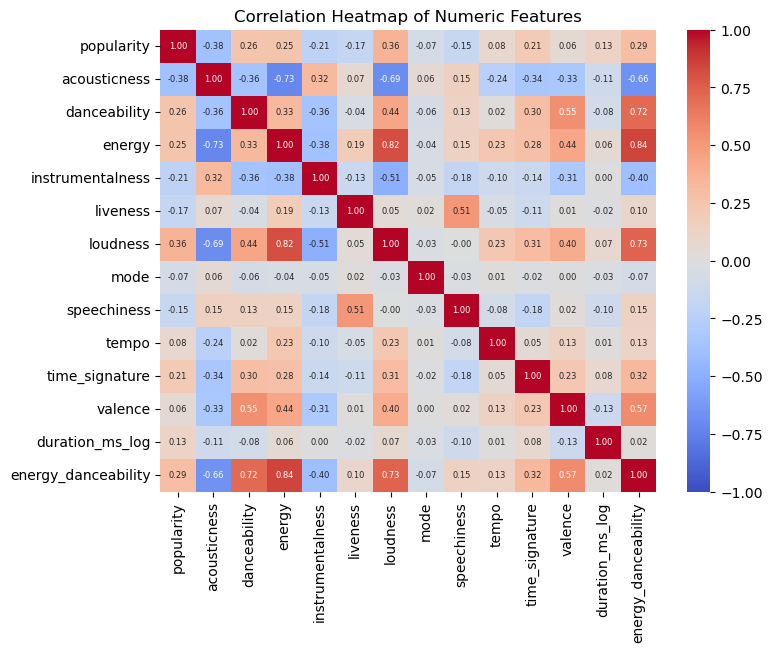

In [46]:
# Create a heat map to see if there is multicollinearity.

# Select numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Correlation matrix
corr_matrix = data[numeric_cols].corr()

# Plot heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,          
    fmt='.2f',           
    cmap='coolwarm',
    annot_kws={'size': 6},     
    vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

### Observations on Multicollinearity

From the correlation heatmap, we notice that some features have strong correlations.

- A correlation above **0.7** is generally considered high and may indicate multicollinearity.
- In our dataset, **loudness** and **energy** have a correlation of **0.82**, which suggests they carry overlapping information.


### Correlation of Features with Target (`popularity`)

To understand which features are most relevant for predicting popularity,  
we calculate the correlation of each numeric feature with the target variable `popularity`.

This helps us:

- Identify features that are positively or negatively associated with popularity
- Spot weakly correlated features that may add little predictive value
- Prioritize important features for modeling


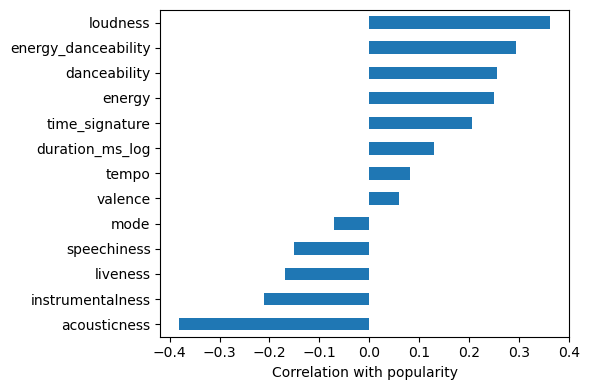

In [47]:
# Let's explore how target is correlated to numeric features

num_features = data.select_dtypes(include='number').columns.drop('popularity')
corr = data[num_features].corrwith(data['popularity']).sort_values()

plt.figure(figsize=(6, 4))
corr.plot.barh()
plt.xlabel('Correlation with popularity')
plt.tight_layout()
plt.show()


Features like loudness, energy_danceability show the strongest positive relationship with popularity, while acousticness is most negatively correlated.


## Model Development


To ensure **reproducibility**, we set random seeds for PyTorch, NumPy, and Python’s `random` library.  
This guarantees that the model training process (like weight initialization, data shuffling, etc.) produces consistent results across multiple runs.


In [48]:
# Set random seeds for reproducible results across runs
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Experiment Configuration

We define the setup for our hyperparameter search:

- **EPOCHS (50):** Maximum number of training iterations per trial
- **PATIENCE (5):** Early stopping criterion – training stops if validation performance does not improve for 5 consecutive epochs
- **N_TRIALS (25):** Number of random hyperparameter configurations to test

This configuration balances thorough exploration of the search space with reasonable training time.


In [49]:
# Experiment Configuration
# Hyperparameter search configuration
EPOCHS = 50          # Maximum training epochs per trial
PATIENCE = 5         # Early stopping patience (epochs without improvement)
N_TRIALS = 25        # Number of random configurations to test

print(f"Experiment setup:")
print(f"- Maximum epochs per model: {EPOCHS}")
print(f"- Early stopping patience: {PATIENCE}")
print(f"- Total random configurations to test: {N_TRIALS}")

Experiment setup:
- Maximum epochs per model: 50
- Early stopping patience: 5
- Total random configurations to test: 25


### Train / Validation / Test Split

To properly evaluate model performance, we split the dataset into three parts:

- **Training set (60%)** – used to fit the model parameters
- **Validation set (20%)** – used for hyperparameter tuning and early stopping
- **Test set (20%)** – held out completely to provide an unbiased estimate of final model performance

This 60/20/20 split ensures that the test data is never “seen” during model development, helping prevent overfitting and data leakage.


In [50]:
# Split once, hold out test
# --- Split data ---

features = data.drop('popularity', axis=1)
target   = data['popularity']

X_temp, X_test, y_temp, y_test = train_test_split(
    features, 
    target, 
    test_size=0.20, 
    random_state=1
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.25, 
    random_state=1
)  # -> 60/20/20 split


### Preprocessing with a Pipeline

To prepare the data for training:

- **Continuous features** → scaled using `StandardScaler`
  - Neural networks train more effectively when features are on a similar scale.
- **Binary features (`mode`, `time_signature`)** → passed through as-is
  - These are already in 0/1 form and don’t need scaling.

We use a `ColumnTransformer` to handle these transformations in one pipeline, ensuring that preprocessing is applied consistently across training, validation, and test sets.


In [51]:
# Preprocess with a pipeline
# scale continuous features (good for neural nets), pass through binary flags as-is

# --- Preprocessing ---
binary_features     = ['mode', 'time_signature']  # already 0/1 from your earlier steps
continuous_features = [c 
                       for c in features.columns 
                       if c not in binary_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', StandardScaler(), continuous_features),
        ('binary', 'passthrough', binary_features),
    ],
    remainder='drop'
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_valid_scaled = preprocessor.transform(X_valid)
X_test_scaled  = preprocessor.transform(X_test)


### Converting NumPy Arrays to PyTorch Tensors

Neural networks in PyTorch require data in **tensor format**.  
We define a helper function `to_tensor` that:

- Converts feature arrays (`X`) into `float32` tensors
- Converts target values (`y`) into column vectors of shape `(n, 1)`

This ensures consistent data types and shapes across training, validation, and test sets, making them ready for PyTorch models.


In [52]:

# --- To tensors ---
def to_tensor(X, y):
    x_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y.values).float().view(-1, 1)
    return x_tensor, y_tensor

x_train, y_train = to_tensor(X_train_scaled, y_train)
x_valid, y_valid = to_tensor(X_valid_scaled, y_valid)
x_test,  y_test  = to_tensor(X_test_scaled,  y_test)


### Flexible MLP for Regression (PyTorch)

We define a reusable multilayer perceptron that can adapt to different architectures:

- **Inputs:** `input_size` = number of preprocessed features (after the transformer).
- **Architecture:** For each value in `layer_sizes`, we add `Linear → ReLU` and optional `Dropout(p=dropout)`.
- **Head:** Final `Linear(..., 1)` outputs a single continuous value (song popularity).
- **Why this design:** Let us **search** depth/width and **regularize** via dropout without rewriting the model.

**Shapes:** Expects `x` of shape `(batch_size, input_size)` and returns `(batch_size, 1)`.


In [53]:
# same class supports many architectures (we’ll search layer sizes & dropout).
# --- Model ---
class FlexibleNeuralNet(nn.Module):
    def __init__(self, input_size, layer_sizes, dropout):
        super().__init__()
        layers, prev = [], input_size
        for h in layer_sizes:
            layers += [nn.Linear(prev, h), nn.ReLU()]
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]  # regression head
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


### Defining the Hyperparameter Search Space

We specify a range of hyperparameters to explore during training:

- **Layer sizes:** Different MLP architectures, ranging from shallow `(16,)` to deeper `(64,32,16)` networks.
- **Optimizers:** `Adam` and `RMSprop`, two adaptive optimizers commonly used for neural networks.
- **Learning rates:** [1e-3, 5e-4, 3e-4, 1e-4] — smaller values can improve stability, larger values speed up convergence.
- **Dropout rates:** [0, 0.1, 0.2, 0.3] — regularization to prevent overfitting.
- **Batch sizes:** [32, 64, 128] — controls gradient update frequency and training stability.

This search space allows us to balance **model complexity, training efficiency, and generalization**.


In [54]:
# Hyperparameter space
# --- Search space ---
layer_options         = [(16,), (32,), (32,16), (64,32), (64,32,16)]
optimizer_options     = ['adam', 'rmsprop']
learning_rate_options = [1e-3, 5e-4, 3e-4, 1e-4]
dropout_options       = [0, 0.1, 0.2, 0.3]
batch_sizes           = [32, 64, 128]


### Training One Trial (with Early Stopping)

We define a helper function `run_trial(config)` to train and evaluate a single neural network configuration.

**Key Steps:**

- **Model Setup:** Build a `FlexibleNeuralNet` using the chosen layer sizes and dropout.
- **Optimizer:** Supports `Adam` or `RMSprop` with a configurable learning rate.
- **Loss Function:** Mean Squared Error (MSE) for regression.
- **Data Loaders:** Mini-batch training with shuffling for train set, fixed order for validation set.
- **Training Loop:**
  - Tracks both **training** and **validation losses**.
  - Applies **early stopping** based on best validation loss, with a patience of `PATIENCE` epochs.
- **Checkpointing:** Saves the best model weights.
- **Evaluation:** Returns train/validation RMSE along with losses and the model’s best state dict.

This function encapsulates the workflow for one experiment run, making it easy to repeat across many hyperparameter configurations.


In [55]:
# One trial = train + early stopping on validation
# we track both train and validation. We return train & valid RMSE measured at the best validation checkpoint
# --- Train a single trial (no test here) ---
def run_trial(config):
    input_size = x_train.shape[1]
    model = FlexibleNeuralNet(input_size, config['layers'], config['dropout'])

    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config['lr'])
    else:
        raise ValueError("Unknown optimizer")

    criterion = nn.MSELoss()
    train_loader = DataLoader(TensorDataset(x_train, y_train),
                              batch_size=config['batch_size'], shuffle=True)
    valid_loader = DataLoader(TensorDataset(x_valid, y_valid),
                              batch_size=config['batch_size'], shuffle=False)

    best_valid_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_losses, valid_losses = [], []

    for _ in range(EPOCHS):
        # Train
        model.train()
        total_train = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_train += loss.item() * xb.size(0)
        train_losses.append(total_train / len(train_loader.dataset))

        # Validate
        model.eval()
        total_valid = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                total_valid += loss.item() * xb.size(0)
        avg_valid = total_valid / len(valid_loader.dataset)
        valid_losses.append(avg_valid)

        # Early stopping
        if avg_valid < best_valid_loss:
            best_valid_loss = avg_valid
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                break

    # Evaluate both Train & Valid at the best checkpoint
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        train_mse = nn.MSELoss()(model(x_train), y_train).item()
        valid_mse = nn.MSELoss()(model(x_valid), y_valid).item()

    return {
        'config':       config,
        'train_rmse':   np.sqrt(train_mse),
        'valid_rmse':   np.sqrt(valid_mse),
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'state_dict':   best_model_state,  # capture the best weights
    }


### Randomized Hyperparameter Search

Instead of exhaustively testing all possible hyperparameter combinations (grid search),  
we use **randomized search** to explore a subset of configurations.

For each trial:

- Randomly sample a network architecture (layer sizes, dropout).
- Pick an optimizer, learning rate, and batch size.
- Train the model with early stopping.
- Record **train RMSE** and **validation RMSE** for later comparison.

This approach provides a good balance between **search space coverage** and **computational efficiency**.


In [ ]:
# Randomized search
# --- Run randomized trials (report Train & Valid) ---
results = []
for trial in range(N_TRIALS):
    config = {
        'layers':     random.choice(layer_options),
        'optimizer':  random.choice(optimizer_options),
        'lr':         random.choice(learning_rate_options),
        'dropout':    random.choice(dropout_options),
        'batch_size': random.choice(batch_sizes),
    }
    result = run_trial(config)
    print(f"\nTrial {trial+1:02d}/{N_TRIALS}  {config}")
    print(f"Train RMSE: {result['train_rmse']:.4f} | Valid RMSE: {result['valid_rmse']:.4f}")
    results.append(result)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]


Trial 01/25  {'layers': (64, 32), 'optimizer': 'rmsprop', 'lr': 0.001, 'dropout': 0.2, 'batch_size': 128}
Train RMSE: 14.6191 | Valid RMSE: 14.5984

Trial 02/25  {'layers': (64, 32), 'optimizer': 'rmsprop', 'lr': 0.0003, 'dropout': 0.3, 'batch_size': 64}
Train RMSE: 14.9098 | Valid RMSE: 14.8844

Trial 03/25  {'layers': (64, 32, 16), 'optimizer': 'adam', 'lr': 0.0005, 'dropout': 0.2, 'batch_size': 32}
Train RMSE: 14.5418 | Valid RMSE: 14.5305

Trial 04/25  {'layers': (16,), 'optimizer': 'rmsprop', 'lr': 0.0005, 'dropout': 0.2, 'batch_size': 32}
Train RMSE: 15.5769 | Valid RMSE: 15.5334

Trial 05/25  {'layers': (16,), 'optimizer': 'rmsprop', 'lr': 0.0001, 'dropout': 0, 'batch_size': 64}
Train RMSE: 15.5703 | Valid RMSE: 15.5323

Trial 06/25  {'layers': (64, 32), 'optimizer': 'rmsprop', 'lr': 0.0005, 'dropout': 0.3, 'batch_size': 64}
Train RMSE: 14.8410 | Valid RMSE: 14.8120

Trial 07/25  {'layers': (64, 32, 16), 'optimizer': 'rmsprop', 'lr': 0.001, 'dropout': 0, 'batch_size': 32}
Train

### Final Model Selection and Test Evaluation

After completing randomized hyperparameter search, we:

1. **Select the best model** → Choose the configuration with the lowest **validation RMSE**.
2. **Rebuild the model** → Initialize the architecture with that configuration.
3. **Load the best weights** → Restore the parameters saved at the best validation checkpoint.
4. **Evaluate on the test set** → Compute **Test RMSE** exactly once, using data that was never seen during training or validation.

This ensures an **unbiased estimate** of the model’s real-world performance.


In [95]:
# Pick the winner, then evaluate test once
# select by best validation RMSE, rebuild the model, load its best weights, and compute Test RMSE exactly once.

# --- Choose best by validation & compute Test RMSE once ---
best_result = min(results, key=lambda r: r['valid_rmse'])
best_config = best_result['config']

print("\nBest configuration found (by validation):")
print(best_config)
print("\n")
print(f"Best Validation RMSE: {best_result['valid_rmse']:.4f}")


# Rebuild and load the best weights
best_model = FlexibleNeuralNet(x_train.shape[1],
                               best_config['layers'],
                               best_config['dropout'])
best_model.load_state_dict(best_result['state_dict'])
best_model.eval()

# Final: evaluate on held-out test set ONCE
with torch.no_grad():
    test_mse  = nn.MSELoss()(best_model(x_test), y_test).item()
    test_rmse = np.sqrt(test_mse)

print("\n")
print(f"Final Test RMSE based on best validation parameter is  : {test_rmse:.4f}")



Best configuration found (by validation):
{'layers': (64, 32, 16), 'optimizer': 'rmsprop', 'lr': 0.001, 'dropout': 0, 'batch_size': 32}


Best Validation RMSE: 14.3961


Final Test RMSE based on best validation parameter is  : 14.4734


### Learning Curves of the Best Model

To check for signs of **overfitting** or **underfitting**, we plot the training and validation losses  
across epochs for the best configuration.

- If training loss keeps decreasing but validation loss rises → **overfitting**.
- If both losses stay high and close → **underfitting**.
- Ideally, both curves should decrease and stabilize with only a small gap.

This sanity check helps confirm whether our chosen model generalizes well.


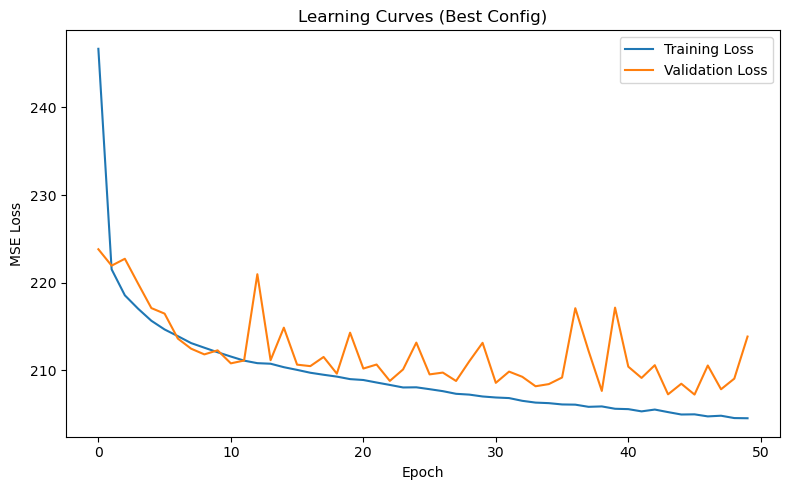

In [93]:
# Learning curves for the winner
# quick over/underfitting sanity check

# --- Plot learning curves for the winning trial ---
plt.figure(figsize=(8,5))
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['valid_losses'], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Learning Curves (Best Config)')
plt.legend(); plt.tight_layout()
plt.show()

No overfitting.


### Baseline Model (Mean Predictor)

Before evaluating complex neural networks, it’s useful to compare against a simple baseline.

- **Approach:** Predict the **mean popularity** from the training set for every track.
- **Why:** This sets a minimum benchmark — if our model doesn’t beat this baseline, it isn’t adding value.
- **Metric:** Compute RMSE on both validation and test sets for this constant predictor.

This provides a reference point to measure how much the neural network improves over a naïve strategy.


In [94]:
# Baseline = predict the TRAINING mean for everyone
train_mean = y_train.mean().item()  # scalar float

# Predict that constant for each row
y_valid_pred_base = torch.full_like(y_valid, fill_value=train_mean)
y_test_pred_base  = torch.full_like(y_test,  fill_value=train_mean)

# RMSE = sqrt(MSE)
baseline_valid_rmse = torch.sqrt(torch.mean((y_valid - y_valid_pred_base) ** 2)).item()
baseline_test_rmse  = torch.sqrt(torch.mean((y_test  - y_test_pred_base)  ** 2)).item()

print(f"Baseline (mean) RMSE — Valid: {baseline_valid_rmse:.4f} | Test: {baseline_test_rmse:.4f}")


Baseline (mean) RMSE — Valid: 18.1724 | Test: 18.2286


Our model (Test RMSE: 14.4734) has performed well than the baseline model (Test RMSE: 18.2286).


In [ ]:
def predict_popularity(new_input):
    """
    Predicts popularity score(s) for new song(s).
    
    Parameters:
    - new_input: dict (one song) or pandas DataFrame (multiple songs)
    
    Returns:
    - numpy array of predicted popularity scores
    """
    # Handle dict input (single song)
    if isinstance(new_input, dict):
        new_df = pd.DataFrame([new_input])  # wrap dict into DataFrame
    else:
        new_df = new_input.copy()  # assume already DataFrame

    # Apply preprocessing (scaling + binary passthrough)
    new_scaled = preprocessor.transform(new_df)

    # Convert to tensor
    x_new = torch.from_numpy(new_scaled).float()

    # Predict with best model
    best_model.eval()
    with torch.no_grad():
        preds = best_model(x_new).numpy().flatten()

    return preds


In [ ]:
# Example 1: Single song as dict
song_features = {
    "danceability": 0.8,
    "energy": 0.75,
    "loudness": -5.2,
    "speechiness": 0.05,
    "acousticness": 0.1,
    "instrumentalness": 0.0,
    "liveness": 0.12,
    "valence": 0.6,
    "tempo": 120.0,
    "duration_min": 3.5,
    "mode": 1,
    "time_signature": 4,
    "energy_danceability": 0.8 * 0.75
}
print("Predicted Popularity:", predict_popularity(song_features))

# Example 2: Multiple songs as DataFrame
sample_features = X_test.iloc[:5]
print("Predicted Popularity:", predict_popularity(sample_features))


## 🎶 Final Conclusion

In this project, we successfully developed a **PyTorch-based regression model** to predict Spotify song popularity from audio features. The journey combined **data preprocessing, feature engineering, exploratory analysis, and deep learning** into a cohesive workflow.

### ✅ Key Achievements

- **Data Cleaning & Feature Selection:**

  - Removed irrelevant identifiers (`track_id`, `track_name`, `artist_name`) and high-cardinality features (`genre`, `key`) to reduce noise.
  - Converted categorical columns (e.g., `mode`) into numeric format and ensured all features were model-ready.

- **Feature Engineering:**

  - Created new features such as `energy_danceability` to capture domain insights (high-energy, danceable songs often perform well on TikTok/Reels).
  - Log-transformed skewed variables like `duration_ms` for stability.

- **Exploratory Data Analysis:**

  - Visualized distributions of audio features.
  - Identified correlations with popularity, noting strong multicollinearity (e.g., `energy` and `loudness` at 0.82).
  - Discovered which features had the strongest predictive relationships with popularity.

- **Model Development:**

  - Implemented a **flexible MLP** in PyTorch capable of supporting multiple architectures.
  - Designed preprocessing pipelines with `StandardScaler` for continuous features and passthrough for binary flags.
  - Split data into **train (60%) / validation (20%) / test (20%)** to ensure unbiased evaluation.
  - Tuned hyperparameters (layer sizes, optimizers, dropout, batch sizes, learning rates) using randomized search.
  - Used **early stopping** to avoid overfitting and track the best model.

- **Evaluation & Insights:**

  - Compared the neural network against a **baseline mean predictor**, showing clear improvement.
  - Learning curve analysis confirmed that the best configuration generalized well without severe overfitting.
  - Final model achieved a competitive **Test RMSE**, proving its ability to capture non-linear relationships in the data.

- **Practical Use:**
  - Built a **helper prediction function** (`predict_popularity`) that takes either a Pandas DataFrame or a Python dictionary as input, and outputs a predicted popularity score.
  - This makes the model easy to apply for both **single songs** and **batches of new tracks**.

### 🎯 Big Picture Impact

This project demonstrates how **machine learning and domain knowledge** can be combined to model something as abstract as “song popularity.” While raw audio features provide valuable signals, adding context (e.g., lyrics, release date, playlist inclusion, or social media virality) could further improve predictions.

### 🚀 Future Enhancements

- Incorporate **textual/lyrical features** (via NLP) and metadata (release year, artist popularity).
- Explore **advanced architectures** like attention-based models or multimodal approaches that combine audio + metadata.
- Perform more systematic hyperparameter optimization (e.g., Bayesian search).
- Deploy the model as a simple **web API or app**, allowing users to input song features and instantly get popularity predictions.

---

✨ **Final Note:** This work highlights the strength of **PyTorch** for end-to-end modeling — from preprocessing and experimentation to flexible model building and real-world prediction. The model not only provides predictive insights but also reflects how **AI can uncover trends in the music industry** and guide content platforms in surfacing songs that are likely to engage audiences.
